## Computational Perception Assignment 1 {-}
Feb 4, 2019

### Q1. Signal Detection Theory (25 points) {-}

Assume you measure a signal plus Gaussian noise: $y = x + n$, where $n \sim N(0, \sigma_n)$. -- I'm assuming you mean $σ_{n}^{2}$

Imports and utility functions:

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [112]:
def gaussian_distribution(mu, sigma_squared):
    return lambda a: np.exp(-(a - mu)**2 / (2 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

def plot_function(f, min=0, max=2, step_size=101, **args):
    x = np.linspace(min, max, step_size)
    y = f(x)
    plt.plot(x, y, **args)


def plot_boundary(x, **args):
    plt.axvline(x, color='red', **args)
    
    
def show_graph():
    plt.grid()
    plt.legend()
    plt.show()


def add_signals(sig_a, sig_b):
    return lambda a: sig_a(a) + sig_b(a)

1.1 Calculate and plot the optimal detection threshold overlaid on the distributions of $n$ and $y$. (5 pts)

Since x is a constant signal, y is simply Gaussian noise plus this constant, and so for y's pdf we just add x to the mean of y's normal distribution, effectively shifting it to the right.  Since the variance of this and the pure noise distribution are the same, the point where they intersect is just the midpoint beween their two means, and since by the definition of a pdf this is where $P(Y|X=x)=P(Y|X=0)$, we know this to be the optimal decision boundary/detection threshold.

In [113]:
def gaussian_noise_distribution(mu, sigma_squared):
    return gaussian_distribution(mu, sigma_squared)


def noisy_signal_distribution(signal_amplitude, mu, sigma_squared):
    return gaussian_noise_distribution(mu+signal_amplitude, sigma_squared)

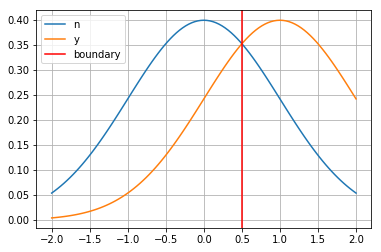

In [114]:
noise_mean, noise_variance = 0, 1
xmin, xmax = -2, 2
signal_amplitude = 1
plot_function(gaussian_noise_distribution(noise_mean, noise_variance), min=xmin, max=xmax, label='n')
plot_function(noisy_signal_distribution(signal_amplitude, noise_mean, noise_variance), min=xmin, max=xmax, label='y')
plot_boundary((2*noise_mean + signal_amplitude)/2, label='boundary')
show_graph()

Generalize this model so that the signal itself is variable, i.e. $x \sim N(\mu_x, \sigma_x)$.  

Since the sum of Gaussians is just a Gaussian whose mean is sum of the component Gaussian means and whose variance is the sum of the component Gaussian variances, the pdf of a noisy variable signal, being the sum of a Gaussian signal and Gaussian noise, is itself a Gaussian:

In [115]:
def noisy_gaussian_signal_distribution(mu_x, sigma_squared_x, mu_n, sigma_squared_n):
    return gaussian_distribution(mu_x + mu_n, sigma_squared_x + sigma_squared_n)

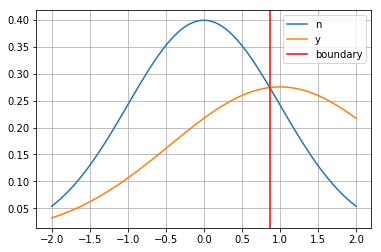

In [123]:
from math import sqrt
import math

sig_mean, sig_variance = 1, 1.1
plot_function(gaussian_noise_distribution(noise_mean, noise_variance), min=xmin, max=xmax, label='n')
plot_function(noisy_gaussian_signal_distribution(sig_mean, sig_variance, noise_mean, noise_variance), min=xmin, max=xmax, label='y')
#plot_boundary((2.0 * noise_mean + sig_mean)/2.0, label='boundary') # TODO: actually plot this right
#a = sig_variance
a = -1/(sig_variance + noise_variance) + 1/noise_variance
b = 2 * (sig_mean + noise_mean) / (sig_variance + noise_variance)
c = -sig_mean**2 /(sig_variance + noise_variance) + math.log(noise_variance/(sig_variance + noise_variance))#-noise_variance * sig_mean**2 * (1 + math.log((sig_variance+noise_variance)/sig_variance)) #(sig_variance + noise_variance)*noise_variance*math.log((sig_variance+noise_variance)/sig_variance)
maybe_boundary = (-b + sqrt(b**2-4*a*c))/(2*a)
plot_boundary(maybe_boundary, label='boundary')
show_graph()

1.2 Derive the distribution of $y$. (5 pts)

Since $y=x+n$, $y∼N(μ_{x}, σ_{x}^{2}) + N(0, σ_{n}) = N(μ_{x}, σ_{x}^{2} + σ_{n}^{2})$ since the sum of Gaussians is Gaussian as stated above.

1.3 Derive the optimal threshold under this model.  State any assumptions you make. (5 pts) 

1.4 What are the expressions for the probability of a successful detection (a true positive) and of a false alarm (a false positive)? (5 pts)

PRIORS ARE VARIABLES/PARAMS IN THE EXPRESSION, NOT JUST 1/2

1.5 Code a functions to calculate these, and use them to plot the ROC curves for different SNRs. Follow the format in Dusenbery-fig.5.2. You should use a toolbox or package that defines common distributions and a cdf function. (5 pts)

In [49]:
def roc_curve(snr):
    tprate, fprate = [], []
    # iteratively find tp and fp rates for different threshold values
    min_threshold, max_threshold = -2.0, 3.0
    threshold_steps = 10
    for threshold in np.linspace(min_threshold, max_threshold, threshold_steps):
        # TODO: actually calculate tp and fp rates
        pass
    return np.divide(tprate, fprate)

In [50]:
def plot_roc_graph(curves):
    plt.xlabel('false alarm')
    plt.ylabel('detection')
    plt.gca().twinx()
    plt.ylabel('miss')
    plt.gca().twiny()
    plt.xlabel('correct null')
    plt.plot(np.linspace(0,1,100))
    for curve in curves:
        plt.plot(np.linspace(0, 1, len(curve)), curve)
    plt.show()

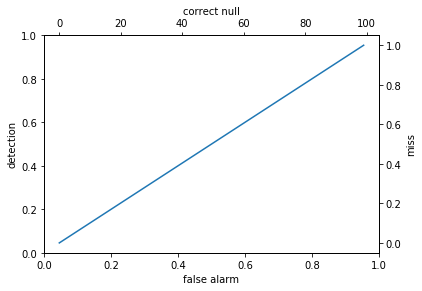

In [51]:
roc_curves = [[.4]] # TODO: this is just a placeholder so it doesn't error, remove it when you actually have roc curves to plot
for snr in range(0, 4):
    roc_curves.append(roc_curve(snr))
plot_roc_graph(roc_curves)

### Q2. Detection in a time-varying signal (15 points) {-}

Now assume your signals are time-varying: $y(t) = x(t) + n(t)$.  Assume again Gaussian noise, $y(t) \sim N(0, \sigma_n)$, and for simplicity, that $t$ is discrete and the measured samples $y(t)$ are independent.  The signal $x(t)$, however, only arrives at random intervals and is zero elsewhere.  Events that arrive at random, independent invervals obey Poisson statistics, and the interval can be modeled with an exponential distribution.

2.1 Write code to generate signals from this model. (5 pts)

In [69]:
# domain: the x axis of the signal
# lamb: lambda parameter of the exponential distribution
def poisson_point_process(domain, lamb):
    # get intervals between signal by sampling from exponential distribution
    # and sample the signal at each of those points from the gaussian
    steps = domain.shape[0]
    codomain = np.zeros(domain.shape)
    step = 0
    while True:
        step += int(np.random.exponential(1.0/lamb))
        if step >= steps:
            return codomain
        else:
            # TODO: ask in class if signal is supposed to be constant or Gaussian, here we're just setting it to a constant
            # he said constant
            codomain[step] = 10 # TODO: I also set this to 2 arbitrarily


def poisson_signal(lamb):
    return lambda a: poisson_point_process(a, lamb)


def noisy_poisson_signal(lamb, mu_n, sigma_squared_n):
    return lambda a: poisson_point_process(a, lamb) + np.random.normal(mu_n, sigma_squared_n**.5, a.shape)

2.2 Derive the optimal threshold detector for this scenario.  Be sure to consider the probability of the signal being present in any particular sample.  Contrast this with the threshold in Q1. (5 pts)

same as q1 sheet, but can simplify more (see scratch paper)

2.3 Write code to plot your generated signal and illustrate threshold detection with a roughly 95% true positive rate. (5 pts)

-1.25
3.3759931063216415


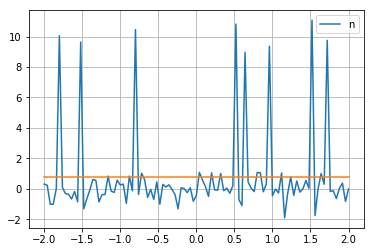

In [124]:
noise_variance = .5
plot_function(noisy_poisson_signal(.1, noise_mean, noise_variance), min=-2, max=2, label='n')

a = -1/(sig_variance + noise_variance) + 1/noise_variance
b = 2 * (sig_mean + noise_mean) / (sig_variance + noise_variance)
c = -sig_mean**2 /(sig_variance + noise_variance) + math.log(noise_variance/(sig_variance + noise_variance))#-noise_variance * sig_mean**2 * (1 + math.log((sig_variance+noise_variance)/sig_variance)) #(sig_variance + noise_variance)*noise_variance*math.log((sig_variance+noise_variance)/sig_variance)

print(-b)
print(sqrt(b**2-4*a*c))
boundary = (-b + sqrt(b**2-4*a*c))/(2*a)
plt.plot(np.linspace(-2, 2, 100), [boundary for _ in range(100)])
show_graph()

### Q3. Spectra and Spectrograms (15 points) {-}

3.1 Read the bach.wav file and plot its Fourier spectrum. (5 pts)

In [188]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')

# normaleze the audio data for easier processing, copied from pgm homework 5
def audionorm(data):
    normalizer = 2**16
    return [i/normalizer for i in data]
    # ensure data is ndarray with float numbers
    #data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    #lbound, ubound = np.min(data), np.max(data)
    #if lbound == ubound:
    #    offset = lbound
    #    scalar = 1
    #    data = np.zeros(size=data.shape)
    #else:
    #    offset = (lbound + ubound) / 2
    #    scalar = 1 / (ubound - lbound)
    #    data = (data - offset) * scalar
    # return normalized data
    #return data

signal = audionorm(dataBach)

In [199]:
# plot the fourier spectrum
from scipy.fftpack import fft

signal = audionorm(dataBach)
signal = abs(fft(signal))

(132362,)


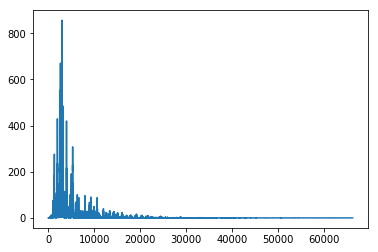

In [200]:
print(signal.shape)
plt.plot(signal[:len(signal)//2])
plt.show()

3.2 Plot the spectrogram (i.e. the time-varying spectrum).  Choose a time interval, windowing, and other parameters such that the individual notes and their harmonics are clearly visible.  Be sure to explain your choices. (5 pts)

In [171]:
def plot_spectrogram(data, time_interval, window_size):
    sampling_frequency = len(data) / time_interval
    plt.xlabel("Time (unit)") # TODO: units
    plt.ylabel("Frequency (unit)") # TODO: units
    plt.specgram(data, Fs=sampling_frequency, NFFT=window_size, window=np.hamming(window_size), noverlap=window_size-1)
    plt.show()

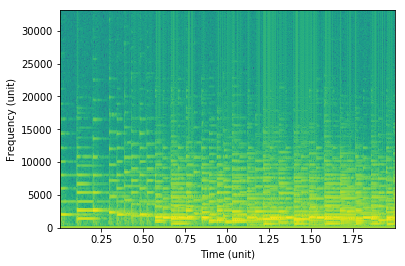

In [14]:
#plot_spectrogram(np.linspace(0, 1, 400), 2, 50)
plot_spectrogram(signal, 2, 400)

3.3 Plot the spectrogram of the first note. Follow the format in AN-fig.1.4.  This note is called $E_5$, which is the E above middle C, and in common tunings has a pitch of 659 Hz.  Show that this note roughly matches this frequency. (5 pts)

In [177]:
import sounddevice as sd

# verify this is only the first note
srate, dataBach = wavfile.read('data/bach.wav')
signal = audionorm(dataBach)
sd.play(signal[:7000], srate)

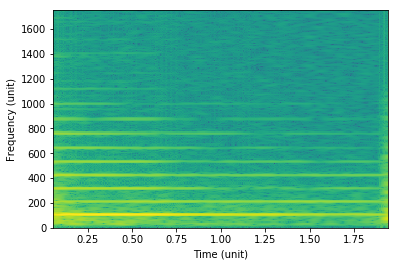

In [172]:
# first let's plot the spectrogram
plot_spectrogram(signal[:7000], 2, 400)

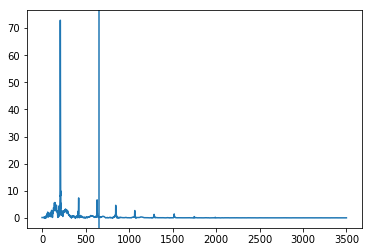

In [342]:
signal = audionorm(dataBach)
trunc_signal = signal[:7000]
f_signal = abs(fft(trunc_signal))
plt.plot(f_signal[:len(f_signal)//2])
plt.axvline(659)

### Q4. Filtering (25 points) {-}

4.1 Write a function to calcuate discrete convolution $y(t) = h(t) * x(t)$.  For pedagogical purposes, do this "by hand", i.e. with for loops, and do not use a built-in function. (5 pts)

$(h*x)(t) = ∑_{𝜏=-∞}^{+∞}h(𝜏)x(t-𝜏)$, but since we can only plot the signal for a discrete window we restrict the sum to within that window in the following convolution function:

In [537]:
def discretely_convolve(h, x):
    y = np.zeros(len(h) + len(x))
    #x = np.pad(x, len(h)-len(x), mode='constant', constant_values=0) # in case the filter is over a smaller domain, zero pad it
    for t in range(len(h) + len(x)): # for all h > x the product is 0 anyway TODO: but we need it to iterate over all of y
        for tau in range(-len(x)//2, len(x)//2): # for all h > x the product is 0 anyway
            if t - tau < len(x):
                y[t] += h[tau] * x[t-tau]
    return y

In [593]:
def discretely_convolve(h, x):
    y = np.zeros(len(h) + len(x))
    x = np.pad(x, (0, len(h)-len(x)), 'constant', constant_values=(0,))
    print(len(x))
    print(len(h))
    print(len(y))
    for t in range(len(y)):
        for tau in range(len(h)):
            if 0 <= t - tau < len(x):
                # print(t-tau)
                y[t] += h[tau] * x[t-tau]
    return y

The convolution can be demonstrated with a square pulse filter:

In [594]:
import numpy.ma as ma

def square_pulse_filter(a): # TODO: rename this
    x = np.zeros(a.shape)
    x[:15] = -1
    x[2:14] = 5
    return x

def square_pulse():
    return lambda a: np.array([0 < xi < 10 for xi in range(len(a))])

101
101
202


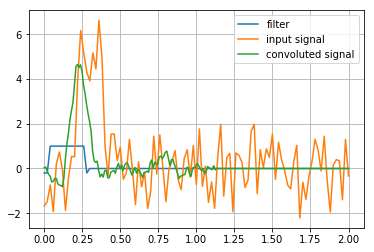

In [595]:
noisy_poisson = lambda a: np.random.normal(0, 1, a.shape)# noisy_poisson_signal(.1, noise_mean, noise_variance)
square_filter = square_pulse_filter(np.linspace(0, 2, 101))*.2
signal = noisy_poisson(np.linspace(0, 2, 101)) + np.roll(square_pulse()(np.linspace(0, 2, 101))*5, 10)
convoluted_signal = discretely_convolve(signal, square_filter)

plt.plot(np.linspace(0, 2, 101), square_filter, label='filter')
plt.plot(np.linspace(0, 2, 101), signal, label='input signal')
# NOTE: I multiplied the convoluted signal by .05 to scale it down for displaying with the other signals, but that's ok
# since the scale isn't the point
plt.plot(np.linspace(0, 2, 202), convoluted_signal*.1, label='convoluted signal')
#plt.plot(np.linspace(0, 2, 201), np.convolve(signal, square_filter), label='np')
show_graph()

4.2. Write code to define a low-pass filter.  A simple low-pass filter is a Gaussian with a width defined in samples.  Convolving this will take a weighted average of the samples around $x(t)$. (5 pts)

In [596]:
# maybe just convolve it manually, pass each point thru the gaussian
def low_pass_filter(signal, filter_width):
    lp_filter = gaussian_distribution(.5, .1)(np.linspace(0, 1, filter_width*2))
    plt.plot(np.linspace(0, 1, 100), np.concatenate((lp_filter, np.zeros(100-len(lp_filter)))), label='filter')
    return discretely_convolve(signal, lp_filter)

The low-pass filter can be demonstrated by applying to a Gaussian-modulated sine wave:

100
100
120


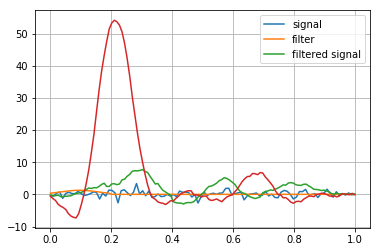

In [599]:
noise = np.random.normal(0, 1, 100) # \gaussian_modulated_sine(100, 100, .5)
#noise = np.ones(100, float) # TODO: remove, something is wrong with convolution
domain = np.linspace(0, 1, 100)
plt.plot(domain, noise, label='signal')
filter_width = 10
#plt.plot(domain, gaussian_distribution(.5, .15)(np.linspace(0, 1, 100)), label='filter')
plt.plot(np.linspace(0, 1, 120), low_pass_filter(noise, filter_width), label='filtered signal')
lp_filter = gaussian_distribution(.5, .1)(np.linspace(0, 1, filter_width*2))
plt.plot(np.linspace(0, 1, 120), np.convolve(signal, lp_filter))
show_graph()
# TODO: this may or may not be working right, it's hard to tell

4.3. Apply your filter to bach.wav.  Illustrate and explain what you did. (5 pts)

7000
7000
7100


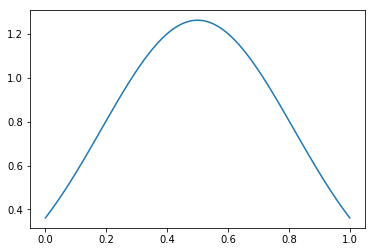

In [600]:
# TODO: it's still not working; it has a huge spike at the start and then nothing
signal = audionorm(dataBach)[:7000]
filtered_signal = low_pass_filter(np.array(signal), 50)


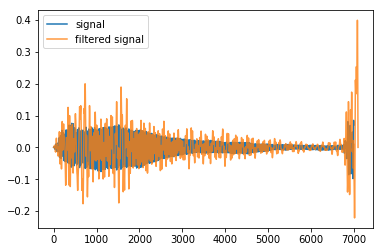

In [601]:
plt.plot(signal, label='signal')
plt.plot(filtered_signal, label='filtered signal', alpha=.8)
plt.legend()
plt.show()
sd.play(filtered_signal, srate)

TODO: explanation

4.4. Write a function for a Gaussian-modulated sine wave.  It should take as parameters, frequency (in Hz), width (in samples), and standard deviation (in secs). (5 pts)

In [226]:
def gaussian_modulated_sine(frequency, width, stddev): # TODO: make sure units are right
    # just multiply the two signals together
    # TODO: none of these units/numbers are actually right, fix them
    domain = np.linspace(-1, 1, width)
    gaussian = gaussian_distribution(0, stddev**2)(domain)
    sine = np.sin(domain*frequency/2)
    print(domain.shape)
    return gaussian * sine

(100,)


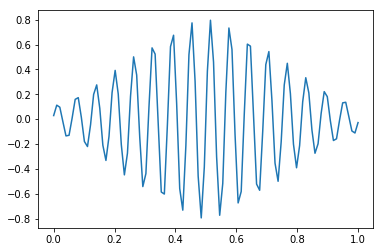

In [227]:
plt.plot(np.linspace(0, 1, 100), gaussian_modulated_sine(100, 100, .5))
plt.show()

4.5 Use your above function to make a "matched" filter for the first note.  Convolve this filter with bach.wav and illustrate the extent to which this simplistic scheme is able to detect occurences of the note $E_5$ in the audio.  For reference, the music, with the $E_5$ notes circled in red is below.  The audio goes a little beyond what is show, but the note doesn't occur there. (5 pts)

![bach.wav music](bach-music.png)

In [526]:
signal = audionorm(dataBach)
#print(signal.shape)
#print(gaussian_modulated_sine(100, 100, .5).shape)
filtered_signal = discretely_convolve(signal, gaussian_modulated_sine(100, 100, .5)) # x in this function is the sine wave
#print(signal.shape)
#print(filtered_signal.shape)

#plt.plot(signal)
plt.plot(filtered_signal)
plt.show()

(100,)


KeyboardInterrupt: 

### Q5. Questions about the Readings (10 points) {-}

5.1 Summarize the evidence that we can detect single photons. (5 pts)

The probability of detecting a signal composed of N photons can be characterized as the pdf of a Poisson random variable, parameterized by the number of photons actually absorbed k.  This fits experimental observations better than other distributions, particularly when k is somewhere in the range of 2-10 photons, meaning that any one photoreceptor almost definitely did not absorb multiple photons given how many exist in the eye, and thus must have detected a single photon.  Additionally, the distribution of intensity scores of visual stimuli in experiments align almost perfectly with this Poisson model.  Furthermore, retinal cells extracted from animals have been shown to respond to single photons with detection accuracy of 99%.  Finally, given the sparsity of photons for the retina to absorb at night, it would not be possible given our current understanding of retinal processing for humans to have nightvision at our known level of effectiveness.

5.2 Summarize the evidence that the some animals can detect sounds that result in *subatomic* vibrations of their eardrum. (5 pts)

Given a model of hearing as a series of instantaneous measurements of hair cell stereocilia, the noise of the signal is equivalent to the equipartition noise of the cilia.  In some animals such as turtles, guinea pigs and cats, this means their cilia have a noise level of only around 1mV, corresponding to a displacement noise on the order of $10^{-10}m$.  Even with this level of accuracy, experiments have shown that hair cells are able to detect signals around 25dB smaller than this estimate, suggesting the existence of a noise-filtering mechanism.  One possibility is an active feedback mechanism from the application of a feedback force, which would reduce thermal noise.  This aligns with observations of acoustic emissions from the ear itself, and with the fact that the probability distribution of sound pressure in the ear is locally minimal around zero, implying an unstable system, and with observed violations of equipartition theorems.  Noise from quantum mechanics is still about an order of magnitude smaller than the signal detection threshold.  Thus, in some cases sound detection is possible at the level of subatomic vibrations.  

### Q6. Exploration (10 points) {-}

In this section, you are meant to do creative exploration.  Select a concept or topic you want to understand better that is related to the problems in this assignment or is in the readings.  Explore it, and write up and illustrate what you tried and learned.  The general idea is for you to teaching yourself, and it should read like a (relatively brief) tutorial.

Here is the grading rubric:

- Was the topic clearly described and concise? (3 pts)

- Were the relevant concepts clearly explained? (3 pts)

- Did the problem go beyond or is distinct from what was already convered in the questions above? (4 pts)

2d convolution for image filter "vertical edge detector" over different orientations

In [602]:
def convolve_2d(h, x):
    y = np.zeros((h.shape[0]+x.shape[0], h.shape[1]+x.shape[1]))
    #x = np.pad(x, (0, len(h)-len(x)), 'constant', constant_values=(0,))
    print(len(x))
    print(len(h))
    print(len(y))
    for row in range(y.shape[0]): # for all h > x the product is 0 anyway TODO: but we need it to iterate over all of y
        for col in range(y.shape[1]):
            for row_tau in range(h.shape[0]): # for all h > x the product is 0 anyway
                for col_tau in range(h.shape[1]):
                    if 0 <= row - row_tau < x.shape[0] and 0 <= col - col_tau < x.shape[1]:
                        y[row, col] += h[row_tau, col_tau] * x[row-row_tau, col-col_tau]
    return y

In [115]:
def convolve_2d(h, x):
    assert len(h.shape) == 2
    assert len(x.shape) == 2
    y = np.zeros(h.shape)
    for row in range(h.shape[0]): # for all h > x the product is 0 anyway TODO: but we need it to iterate over all of y
        for col in range(h.shape[1]):
            for row_tau in range(x.shape[0], x.shape[0]//2): # for all h > x the product is 0 anyway
                for col_tau in range(-x.shape[1]//2, x.shape[1]//2):
                    if row - row_tau < x.shape[0] and col - col_tau < x.shape[1]:
                        y[row, col] += h[row_tau, col_tau] * x[row-row_tau, col-col_tau]
    return y

In [603]:
def show_image_convolution(img, img_filter):
    convoluted_img = convolve_2d(img, img_filter)
    print('INPUT')
    plt.imshow(img, cmap='gray')
    plt.show()
    print('FILTER')
    plt.imshow(img_filter, cmap='gray')
    plt.show()
    print('OUTPUT')
    plt.imshow(convoluted_img, cmap='gray')
    plt.show()

4
16
20
INPUT


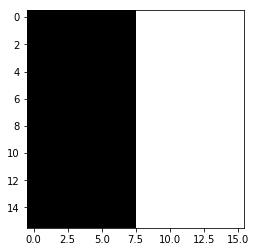

FILTER


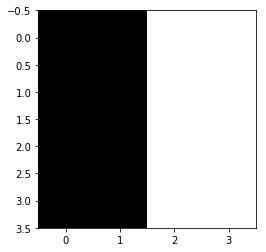

OUTPUT


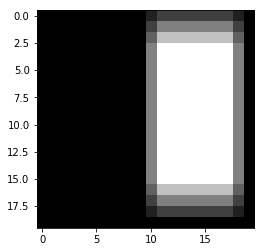

In [612]:
img = np.zeros((16, 16))
img[:,8:] = 1
img_filter = np.zeros((4, 4))
img_filter[:,2:] = 1
show_image_convolution(img, img_filter)

4
16
20
INPUT


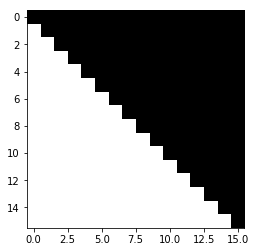

FILTER


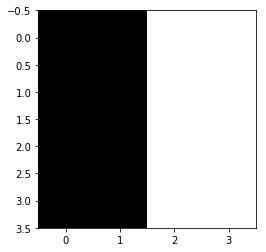

OUTPUT


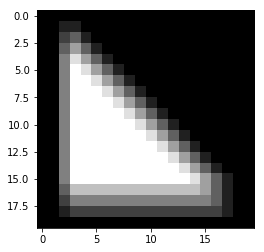

In [613]:
img = np.zeros((16, 16))
for r in range(len(img)):
    for c in range(r):
        img[r,c] = 1
#img[8:,:] = 1
img_filter = np.zeros((4, 4))
img_filter[:,2:] = 1
show_image_convolution(img, img_filter)

4
16
20
INPUT


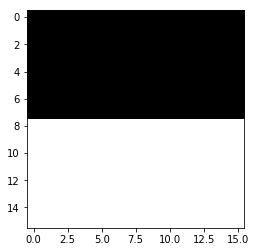

FILTER


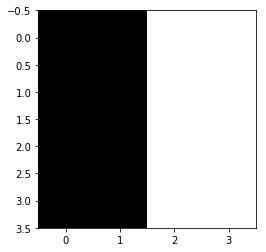

OUTPUT


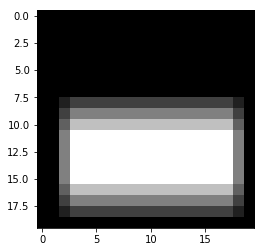

In [614]:
img = np.zeros((16, 16))
img[8:,:] = 1
img_filter = np.zeros((4, 4))
img_filter[:,2:] = 1
show_image_convolution(img, img_filter)

TODO: convolute one image with a bunch of filters with edges at different orientations and plot their responses at the center pixel(s) of the image